- Gestión dinámica de inventario día a día (físico y digital).
- Política de reabastecimiento up-to-level (Q_i, T).
- Cálculo de costos y métricas diarias.
- Modelo de aceptación de despacho express.


## Carga de Datos Reales y Configuración Inicial

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [2]:
# Función para cargar ventas
def cargar_ventas(ruta_base):
    ventas = []
    for dia in range(1, 41):
        archivo = f"{ruta_base}_{dia}_20250115.csv"
        if os.path.exists(archivo):
            df = pd.read_csv(archivo)
            df['dia'] = dia
            ventas.append(df)
    return pd.concat(ventas, ignore_index=True)

# Carga de datos únicos
flota = pd.read_csv('flota_20250115.csv')
productos = pd.read_csv('productos_20250115.csv')
proporcion_eleccion = pd.read_csv('proporcion_eleccion_de_usuarios_20250115.csv')
#demanda_insatisfecha = pd.read_csv('demanda_online_insatisfecha_20250115.csv')
reorden = pd.read_csv('reorden_20250115.csv')
tiendas = pd.read_csv('tiendas_20250115.csv')
vehiculos = pd.read_csv('vehiculos_20250115.csv')
zonas = pd.read_csv('zonas_20250115.csv')

# Carga de ventas físicas y digitales
ventas_tienda = cargar_ventas('venta_tienda')
ventas_tienda.rename(columns={'venta_tienda': 'cantidad'}, inplace=True)

ventas_zona = cargar_ventas('venta_zona')
ventas_zona.rename(columns={'venta_digital': 'cantidad'}, inplace=True)

costo_inventario_unitario = 3.733

Generar resumen tiendas con parametros:

In [3]:
from scipy.stats import norm, lognorm, gamma, poisson
import numpy as np
import pandas as pd

# === 1. Usar SOLO ventas físicas ===
ventas_fisicas = ventas_tienda[['id_producto', 'cantidad']]

# === 2. Ajustar distribuciones por producto ===
parametros_tienda = []

for id_producto, grupo in ventas_fisicas.groupby("id_producto"):
    cantidades = grupo["cantidad"].values
    positivas = cantidades[cantidades > 0]

    # Normal
    mu, sigma = norm.fit(cantidades)
    parametros_tienda.append({
        'id_producto': id_producto,
        'distribucion': 'Normal',
        'parametro1': mu,
        'parametro2': sigma
    })

    # Log-Normal
    if len(positivas) > 0:
        try:
            shape, loc, scale = lognorm.fit(positivas, floc=0)
            mu_ln = np.log(scale)
            sigma_ln = shape
            parametros_tienda.append({
                'id_producto': id_producto,
                'distribucion': 'Log-Normal',
                'parametro1': mu_ln,
                'parametro2': sigma_ln
            })
        except:
            pass

    # Gamma
    if len(positivas) > 0:
        try:
            shape_g, loc_g, scale_g = gamma.fit(positivas, floc=0)
            parametros_tienda.append({
                'id_producto': id_producto,
                'distribucion': 'Gamma',
                'parametro1': shape_g,
                'parametro2': scale_g
            })
        except:
            pass

    # Poisson
    lambda_p = cantidades.mean()
    parametros_tienda.append({
        'id_producto': id_producto,
        'distribucion': 'Poisson',
        'parametro1': lambda_p,
        'parametro2': None
    })

df_param_tienda = pd.DataFrame(parametros_tienda)

# === 3. Fusionar con archivo resumen original (para tomar el mejor ajuste) ===
resumen_tienda = pd.read_excel('resumen_tiendas.xlsx')

df_tienda_completo = resumen_tienda.merge(
    df_param_tienda,
    left_on=['id_producto', 'mejor_ajuste'],
    right_on=['id_producto', 'distribucion'],
    how='left'
)

df_tienda_completo.drop(columns=['distribucion'], inplace=True)

# === 4. Guardar Excel final ===
df_tienda_completo.to_excel('resumen_tiendas_con_parametros.xlsx', index=False)


Generar resumen zonas con parametros:

In [4]:
# === 1. Ajuste sobre ventas digitales (zonas) ===
parametros_zona = []

for id_producto, grupo in ventas_zona.groupby("id_producto"):
    cantidades = grupo["cantidad"].values
    positivas = cantidades[cantidades > 0]

    # Normal
    mu, sigma = norm.fit(cantidades)
    parametros_zona.append({'id_producto': id_producto, 'distribucion': 'Normal', 'parametro1': mu, 'parametro2': sigma})

    # Log-Normal
    if len(positivas) > 0:
        try:
            shape, loc, scale = lognorm.fit(positivas, floc=0)
            mu_ln = np.log(scale)
            sigma_ln = shape
            parametros_zona.append({
                'id_producto': id_producto,
                'distribucion': 'Log-Normal',
                'parametro1': mu_ln,
                'parametro2': sigma_ln
            })
        except:
            pass

    # Gamma
    if len(positivas) > 0:
        try:
            shape_g, loc_g, scale_g = gamma.fit(positivas, floc=0)
            parametros_zona.append({
                'id_producto': id_producto,
                'distribucion': 'Gamma',
                'parametro1': shape_g,
                'parametro2': scale_g
            })
        except:
            pass

    # Poisson
    lambda_p = cantidades.mean()
    parametros_zona.append({'id_producto': id_producto, 'distribucion': 'Poisson', 'parametro1': lambda_p, 'parametro2': None})

df_param_zona = pd.DataFrame(parametros_zona)

# === 2. Fusionar con el resumen original de zonas
resumen_zona = pd.read_excel('resumen_zonas.xlsx')

df_zona_completo = resumen_zona.merge(
    df_param_zona,
    left_on=['id_producto', 'mejor_ajuste'],
    right_on=['id_producto', 'distribucion'],
    how='left'
)

df_zona_completo.drop(columns=['distribucion'], inplace=True)

# === 3. Guardar
df_zona_completo.to_excel('resumen_zonas_con_parametros.xlsx', index=False)


C:\Users\raulr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\stats\_continuous_distns.py:3736: RuntimeWarning: divide by zero encountered in scalar divide
  aest = (3-s + np.sqrt((s-3)**2 + 24*s)) / (12*s)
C:\Users\raulr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\stats\_continuous_distns.py:3739: RuntimeWarning: invalid value encountered in scalar subtract
  a = optimize.brentq(lambda a: np.log(a) - sc.digamma(a) - s,


GENERAR DEMANDA

In [5]:
import pandas as pd
import numpy as np
from scipy.stats import norm, lognorm, gamma, poisson
import os

# Leer los parámetros por producto
resumen_zonas_con_param = pd.read_excel('resumen_zonas_con_parametros.xlsx')
resumen_zonas_con_param.set_index('id_producto', inplace=True)

def generar_variacion_estocastica(distribucion, param1, param2=None):
    if pd.isna(param1) or (param2 is not None and pd.isna(param2)):
        return 1.0

    if distribucion == "Poisson":
        variacion = np.random.poisson(lam=param1) / param1 if param1 > 0 else 1.0
    elif distribucion == "Normal":
        if param2 is None or param2 <= 0:
            return 1.0
        variacion = np.random.normal(loc=param1, scale=param2) / param1 if param1 > 0 else 1.0
    elif distribucion == "Uniforme":
        if param2 is None:
            return 1.0
        variacion = np.random.uniform(low=param1, high=param2) / ((param1 + param2) / 2)
    elif distribucion in ["Log-Normal", "LogNormal"]:
        if param2 is None or param2 <= 0:
            return 1.0
        variacion = np.random.lognormal(mean=param1, sigma=param2) / np.exp(param1)
    elif distribucion == "Gamma":
        if param2 is None or param2 <= 0:
            return 1.0
        variacion = np.random.gamma(shape=param1, scale=param2) / (param1 * param2)
    else:
        return 1.0

    return max(0.7, min(variacion, 1.3))



DEMANDA DIGITAL

In [6]:
# === FUNCIÓN PRINCIPAL PARA UN DÍA ===
def generar_demanda_digital_estocastica(ventas_zona_dia):
    demanda_estocastica = []

    for _, row in ventas_zona_dia.iterrows():
        id_zona = row['id_zona']
        id_producto = row['id_producto']
        base = row['cantidad']

        if id_producto not in resumen_zonas_con_param.index:
            total = base
        else:
            fila = resumen_zonas_con_param.loc[id_producto]
            dist = fila['mejor_ajuste']
            p1 = fila['parametro1']
            p2 = fila['parametro2'] if not pd.isna(fila['parametro2']) else None
            variacion = generar_variacion_estocastica(dist, p1, p2)
            total = max(0, int(base + variacion))

        demanda_estocastica.append({
            'id_zona': id_zona,
            'id_producto': id_producto,
            'venta_digital': total
        })

    return pd.DataFrame(demanda_estocastica)


Generar demanda digital para los 40 días

In [7]:
import os
import pandas as pd

def generar_ventas_zona_estocasticas(ruta_base_original='venta_zona', carpeta_salida='ventas_zona_estocasticas', dias=40):
    """
    Genera archivos estocásticos tipo venta_zona_dia_X.csv en base a archivos de ventas digitales originales.
    
    - ruta_base_original: nombre base de los archivos originales (sin _n_20250115.csv)
    - carpeta_salida: carpeta donde guardar los nuevos archivos
    - dias: cantidad de días a simular (por defecto: 40)
    """
    if not os.path.exists(carpeta_salida):
        os.makedirs(carpeta_salida)

    for dia in range(1, dias + 1):
        archivo_original = f"{ruta_base_original}_{dia}_20250115.csv"
        if not os.path.exists(archivo_original):
            print(f"⚠️ Archivo no encontrado: {archivo_original}")
            continue

        ventas_zona_dia = pd.read_csv(archivo_original)
        ventas_zona_dia.rename(columns={'venta_digital': 'cantidad'}, inplace=True)

        # Aplicar variación estocástica
        ventas_estocasticas = generar_demanda_digital_estocastica(ventas_zona_dia)

        # Guardar archivo con el nuevo nombre
        nombre_salida = os.path.join(carpeta_salida, f"venta_zona_dia_{dia}.csv")
        ventas_estocasticas.to_csv(nombre_salida, index=False)

        print(f"✅ Generado: {nombre_salida}")



TIENDAS MAPEADAS EN ZONAS (CORRER UNA SOLA VEZ)

In [8]:
zonas = pd.read_csv('zonas_20250115.csv')  # Contiene columna tienda_zona
ventas_zona = ventas_zona.merge(zonas[['id_zona', 'tienda_zona']], on='id_zona')
ventas_zona.rename(columns={'tienda_zona': 'id_tienda'}, inplace=True)


## Simulación de Consumo y Reabastecimiento Día a Día 

In [9]:
import pandas as pd
import numpy as np
from scipy.stats import norm, lognorm, gamma, poisson
import os


distribuciones_tienda = pd.read_excel('resumen_tiendas_con_parametros.xlsx')
distribuciones_zona = pd.read_excel('resumen_zonas_con_parametros.xlsx')



In [10]:
def simulacion_unificada(distribuciones_tienda, distribuciones_zona,
                         ventas_tienda, ventas_zona, reorden,
                         dias_simulados=10, frecuencia_reabastecimiento=5,
                         costo_inventario_unitario=3.733, reorden_multiplicador=1.0, semilla=42):

    np.random.seed(semilla)

    # Ajustar reorden
    reorden_mod = reorden.copy()
    reorden_mod['reorden'] = (reorden_mod['reorden'] * reorden_multiplicador).clip(lower=1).astype(int)

    # Diccionarios rápidos
    dist_tienda_dict = distribuciones_tienda.set_index('id_producto')[['mejor_ajuste', 'parametro1', 'parametro2']].to_dict('index')
    dist_zona_dict = distribuciones_zona.set_index('id_producto')[['mejor_ajuste', 'parametro1', 'parametro2']].to_dict('index')

    # Inicializar stock
    stock = reorden_mod[['id_tienda', 'id_producto', 'reorden']].copy()
    stock['stock_actual'] = stock['reorden']
    stock.set_index(['id_tienda', 'id_producto'], inplace=True)
    stock_dia = []

    registro_dia_a_dia = []
    costos_diarios = []

    for dia in range(1, dias_simulados + 1):
        vt = ventas_tienda[ventas_tienda['dia'] == dia][['id_tienda', 'id_producto', 'cantidad']]
        vz = ventas_zona[ventas_zona['dia'] == dia][['id_tienda', 'id_producto', 'cantidad']]
        demanda = pd.concat([vt, vz], ignore_index=True)

        demanda_total = demanda.groupby(['id_tienda', 'id_producto'])['cantidad'].sum().reset_index()

        # Generar variación estocástica
        demanda_total['variacion'] = demanda_total.apply(
            lambda row: generar_variacion_estocastica(
                *(dist_tienda_dict.get(row['id_producto']) or dist_zona_dict.get(row['id_producto']) or ('Constante', 1.0, None))
            ),
            axis=1
        )
        demanda_total['cantidad_ajustada'] = (demanda_total['cantidad'] * demanda_total['variacion']).round().astype(int)

        for _, row in demanda_total.iterrows():
            clave = (row['id_tienda'], row['id_producto'])
            if clave in stock.index:
                disponible = stock.at[clave, 'stock_actual']
                atendido = min(disponible, row['cantidad_ajustada'])
                no_atendido = row['cantidad_ajustada'] - atendido
                stock.at[clave, 'stock_actual'] -= atendido

                registro_dia_a_dia.append({
                    'dia': dia,
                    'id_tienda': row['id_tienda'],
                    'id_producto': row['id_producto'],
                    'demanda': row['cantidad_ajustada'],
                    'atendido': atendido,
                    'no_atendido': no_atendido,
                    'stock_restante': stock.at[clave, 'stock_actual']
                })

        stock_total = stock['stock_actual'].sum()
        costos_diarios.append(stock_total * costo_inventario_unitario)

        df_stock_dia = stock.reset_index().copy()
        df_stock_dia['dia'] = dia
        df_stock_dia['reorden'] = reorden_mod.set_index(['id_tienda', 'id_producto']).loc[stock.index, 'reorden'].values
        stock_dia.append(df_stock_dia)
        

        if dia % frecuencia_reabastecimiento == 0:
            stock['stock_actual'] += stock['reorden'] - stock['stock_actual']

    resultados_df = pd.DataFrame(registro_dia_a_dia)
    df_stock_diario = pd.concat(stock_dia, ignore_index=True)
    
    demanda_total = resultados_df['demanda'].sum()
    atendido_total = resultados_df['atendido'].sum()
    no_atendido_total = resultados_df['no_atendido'].sum()
    costo_total = sum(costos_diarios)
    

    return {
        'nivel_servicio': atendido_total / demanda_total if demanda_total > 0 else 0,
        'costo_total': costo_total,
        'costo_diario_promedio': costo_total / dias_simulados,
        'demanda_no_atendida_total': no_atendido_total,
        'costos_diarios': costos_diarios,
        'registro_dia_a_dia': resultados_df,
        'stock_diario': df_stock_diario
    }


## CASO BASE

In [11]:
resultados = simulacion_unificada(
    distribuciones_tienda=distribuciones_tienda,
    distribuciones_zona=distribuciones_zona,
    ventas_tienda=ventas_tienda,
    ventas_zona=ventas_zona,
    reorden=reorden,
    dias_simulados=40,
    frecuencia_reabastecimiento=5,
    costo_inventario_unitario=3.733,
    reorden_multiplicador=1.0
)

print(f"Nivel de servicio: {resultados['nivel_servicio']:.2%}")
print(f"Costo total: ${resultados['costo_total']:,.0f}")
print(f"Costo diario promedio: ${resultados['costo_diario_promedio']:,.0f}")
print(f"Demanda no atendida total: {resultados['demanda_no_atendida_total']:,}")


Nivel de servicio: 99.90%
Costo total: $14,086,316,989
Costo diario promedio: $352,157,925
Demanda no atendida total: 1,861,740.0


STOCK DIARIO CASO BASE

In [28]:
stock_diario_df = resultados['stock_diario']
display(stock_diario_df)

#stock_diario_df.to_csv("stock_diario.csv", index=False)


,id_tienda,id_producto,reorden,stock_actual,dia
0,1,1,240,193,1
1,1,2,11005,8917,1
2,1,3,11915,9510,1
3,1,4,19180,15293,1
4,1,5,685,551,1
...,...,...,...,...,...
689515,17,1010,7280,389,40
689516,17,1011,345,8,40
689517,17,1012,7095,200,40
689518,17,1013,1305,110,40


COSTOS DIARIOS CASO BASE

In [ ]:
costos_diarios = resultados['costos_diarios']

df_costos_diarios = pd.DataFrame({
    "dia": list(range(1, len(costos_diarios) + 1)),
    "costo_inventario": costos_diarios
})
display(df_costos_diarios)

#df_costos_diarios.to_csv("costos_diarios.csv", index=False)

,dia,costo_inventario
0,1,6.838757e+08
1,2,5.180430e+08
2,3,3.521940e+08
3,4,1.863438e+08
4,5,2.050196e+07
5,6,6.838699e+08
6,7,5.179497e+08
7,8,3.521132e+08
8,9,1.862388e+08
9,10,2.054601e+07


<Axes: xlabel='dia'>

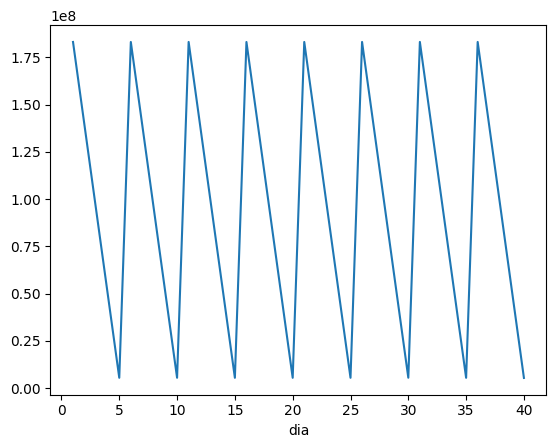

In [14]:
resultados['stock_diario'].groupby('dia')['stock_actual'].sum().plot()


## Simulación con Optuna

In [15]:
def objetivo_con_penalizacion(trial):
    frecuencia_reabastecimiento = trial.suggest_int("frecuencia_reabastecimiento", 2, 7)
    reorden_multiplicador = trial.suggest_float("reorden_multiplicador", 0.05, 2.0)  # Puedes ajustar el rango

    resultados = simulacion_unificada(
        distribuciones_tienda=distribuciones_tienda,
        distribuciones_zona=distribuciones_zona,
        ventas_tienda=ventas_tienda,
        ventas_zona=ventas_zona,
        reorden=reorden,
        dias_simulados=40,
        frecuencia_reabastecimiento=frecuencia_reabastecimiento,
        costo_inventario_unitario=3.733,
        reorden_multiplicador=reorden_multiplicador
    )

    if resultados['nivel_servicio'] < 0.99:
        return resultados['costo_total'] + 1e15  # Penalización dura
    else:
        return resultados['costo_total']


In [16]:
import optuna

estudio = optuna.create_study(direction="minimize")
estudio.optimize(objetivo_con_penalizacion, n_trials=30)

# Ver mejores parámetros
print("🏆 Mejor política encontrada:")
print(estudio.best_params)


C:\Users\raulr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-06-16 01:48:13,127] A new study created in memory with name: no-name-630baa63-a8cd-40a2-b9bb-67f9e9d72d94
[I 2025-06-16 01:51:26,893] Trial 0 finished with value: 30770902728.645008 and parameters: {'frecuencia_reabastecimiento': 6, 'reorden_multiplicador': 1.569498547914504}. Best is trial 0 with value: 30770902728.645008.
[I 2025-06-16 01:55:08,188] Trial 1 finished with value: 1000008560599988.2 and parameters: {'frecuencia_reabastecimiento': 6, 'reorden_multiplicador': 0.8481703971002396}. Best is trial 0 with value: 30770902728.645008.
[I 2025-06-16 01:58:27,730] Trial 2 finished with value: 41933788171.047005 and parameters: {'frecuen

🏆 Mejor política encontrada:
{'frecuencia_reabastecimiento': 2, 'reorden_multiplicador': 0.4069258288530817}


In [48]:
resultados_finales = simulacion_unificada(
    distribuciones_tienda=distribuciones_tienda,
    distribuciones_zona=distribuciones_zona,
    ventas_tienda=ventas_tienda,
    ventas_zona=ventas_zona,
    reorden_multiplicador=0.4069258288530817,
    reorden=reorden,
    dias_simulados=40,
    frecuencia_reabastecimiento=2,
    costo_inventario_unitario=3.733
)

print("\n📊 Resultados finales de la mejor política:")
print(f"📦 Nivel de servicio: {resultados_finales['nivel_servicio']:.2%}")
print(f"💰 Costo total inventario: ${resultados_finales['costo_total']:,.0f}")
print(f"Costo diario promedio: ${resultados_finales['costo_diario_promedio']:,.0f}")
print(f"🚫 Demanda no atendida total: {resultados_finales['demanda_no_atendida_total']:,}")



📊 Resultados finales de la mejor política:
📦 Nivel de servicio: 99.90%
💰 Costo total inventario: $3,874,818,335
Costo diario promedio: $96,870,458
🚫 Demanda no atendida total: 1,725,735.0


STOCK DIARIO VALOR OPTUNA

In [49]:
stock_diario_opt_df = resultados_finales['stock_diario']
display(stock_diario_opt_df)


,id_tienda,id_producto,reorden,stock_actual,dia
0,1,1,97,50,1
1,1,2,4478,2390,1
2,1,3,4848,2443,1
3,1,4,7804,3917,1
4,1,5,278,144,1
...,...,...,...,...,...
689515,17,1010,2962,19,40
689516,17,1011,140,5,40
689517,17,1012,2887,147,40
689518,17,1013,531,49,40


COSTOS DIARIOS VALOR OPTUNA

In [54]:
costos_diarios_opt = resultados_finales['costos_diarios']

df_costos_diarios_opt = pd.DataFrame({
    "dia": list(range(1, len(costos_diarios_opt) + 1)),
    "costo_inventario": costos_diarios_opt
})
display(df_costos_diarios_opt)

df_costos_diarios_opt.to_csv("costos_diarios.csv", index=False)

,dia,costo_inventario
0,1,1.798547e+08
1,2,1.432085e+07
2,3,1.799208e+08
3,4,1.437007e+07
4,5,1.790602e+08
5,6,1.350821e+07
6,7,1.798495e+08
7,8,1.433229e+07
8,9,1.798953e+08
9,10,1.371899e+07


Mejora respecto a caso base:

In [51]:
costo_caso_base=14086316989
costo_sol_opt = 3874818335
mejora=costo_caso_base-costo_sol_opt
mejora_segun_caso_base = mejora/costo_caso_base*100
print(f"{mejora_segun_caso_base}%")

proporcion_del_optimo = costo_sol_opt / costo_caso_base * 100
print(f"{proporcion_del_optimo}%")


72.49232472884258%
27.50767527115742%


## Análisis de sensibilidad con vecinos

In [52]:
resultados_finales_2 = simulacion_unificada(
    distribuciones_tienda=distribuciones_tienda,
    distribuciones_zona=distribuciones_zona,
    ventas_tienda=ventas_tienda,
    ventas_zona=ventas_zona,
    reorden_multiplicador=0.375,
    reorden=reorden,
    dias_simulados=40,
    frecuencia_reabastecimiento=2,
    costo_inventario_unitario=3.733
)

print("\n📊 Resultados finales de la mejor política:")
print(f"📦 Nivel de servicio: {resultados_finales_2['nivel_servicio']:.2%}")
print(f"💰 Costo total inventario: ${resultados_finales_2['costo_total']:,.0f}")
print(f"Costo diario promedio: ${resultados_finales_2['costo_diario_promedio']:,.0f}")
print(f"🚫 Demanda no atendida total: {resultados_finales_2['demanda_no_atendida_total']:,}")


KeyboardInterrupt: 

In [43]:
resultados_finales_3 = simulacion_unificada(
    distribuciones_tienda=distribuciones_tienda,
    distribuciones_zona=distribuciones_zona,
    ventas_tienda=ventas_tienda,
    ventas_zona=ventas_zona,
    reorden_multiplicador=0.395,
    reorden=reorden,
    dias_simulados=40,
    frecuencia_reabastecimiento=2,
    costo_inventario_unitario=3.733
)

print("\n📊 Resultados finales de la mejor política:")
print(f"📦 Nivel de servicio: {resultados_finales_3['nivel_servicio']:.2%}")
print(f"💰 Costo total inventario: ${resultados_finales_3['costo_total']:,.0f}")
print(f"Costo diario promedio: ${resultados_finales_3['costo_diario_promedio']:,.0f}")
print(f"🚫 Demanda no atendida total: {resultados_finales_3['demanda_no_atendida_total']:,}")



📊 Resultados finales de la mejor política:
📦 Nivel de servicio: 99.31%
💰 Costo total inventario: $3,508,720,666
Costo diario promedio: $87,718,017
🚫 Demanda no atendida total: 12,235,887.0


In [44]:
resultados_finales_4 = simulacion_unificada(
    distribuciones_tienda=distribuciones_tienda,
    distribuciones_zona=distribuciones_zona,
    ventas_tienda=ventas_tienda,
    ventas_zona=ventas_zona,
    reorden_multiplicador=0.3925,
    reorden=reorden,
    dias_simulados=40,
    frecuencia_reabastecimiento=2,
    costo_inventario_unitario=3.733
)

print("\n📊 Resultados finales de la mejor política:")
print(f"📦 Nivel de servicio: {resultados_finales_4['nivel_servicio']:.2%}")
print(f"💰 Costo total inventario: ${resultados_finales_4['costo_total']:,.0f}")
print(f"Costo diario promedio: ${resultados_finales_4['costo_diario_promedio']:,.0f}")
print(f"🚫 Demanda no atendida total: {resultados_finales_4['demanda_no_atendida_total']:,}")



📊 Resultados finales de la mejor política:
📦 Nivel de servicio: 99.05%
💰 Costo total inventario: $3,441,196,415
Costo diario promedio: $86,029,910
🚫 Demanda no atendida total: 16,922,179.0


In [46]:
costo_caso_base=14086316989
costo_sol_vec = 3441196415
mejora=costo_caso_base-costo_sol_vec
mejora_segun_caso_base = mejora/costo_caso_base*100
print(f"{mejora_segun_caso_base}%")

proporcion_del_optimo = costo_sol_vec / costo_caso_base * 100
print(f"{proporcion_del_optimo}%")


75.57064477757224%
24.429355222427755%


STOCK DIARIO VALOR VECINO

In [57]:
stock_diario_vec_df = resultados_finales_4['stock_diario']
display(stock_diario_vec_df)

stock_diario_vec_df.to_csv("stock_diario.csv", index=False)


,id_tienda,id_producto,reorden,stock_actual,dia
0,1,1,94,47,1
1,1,2,4319,2231,1
2,1,3,4676,2271,1
3,1,4,7528,3641,1
4,1,5,268,134,1
...,...,...,...,...,...
689515,17,1010,2857,0,40
689516,17,1011,135,0,40
689517,17,1012,2784,44,40
689518,17,1013,512,30,40


COSTOS DIARIOS VALOR VECINO

In [56]:
costos_diarios_vec = resultados_finales_4['costos_diarios']

df_costos_diarios_vec = pd.DataFrame({
    "dia": list(range(1, len(costos_diarios_vec) + 1)),
    "costo_inventario": costos_diarios_vec
})
display(df_costos_diarios_vec)

df_costos_diarios_vec.to_csv("costos_diarios.csv", index=False)

,dia,costo_inventario
0,1,1.675959e+08
1,2,4.793885e+06
2,3,1.676620e+08
3,4,4.812957e+06
4,5,1.668015e+08
5,6,4.286231e+06
6,7,1.675908e+08
7,8,4.782324e+06
8,9,1.676366e+08
9,10,4.368536e+06


----------------------------

In [22]:
zonas = pd.read_csv("zonas_20250115.csv")
conteo_zonas = zonas['tienda_zona'].value_counts().reset_index()
conteo_zonas.columns = ['id_tienda', 'n_zonas']

print("Zonas asignadas por tienda:")
display(conteo_zonas.sort_values('n_zonas', ascending=False))

Zonas asignadas por tienda:


,id_tienda,n_zonas
0,5,266
1,11,216
2,6,189
3,9,184
4,10,145
5,7,144
6,1,130
7,8,124
8,4,119
9,16,103


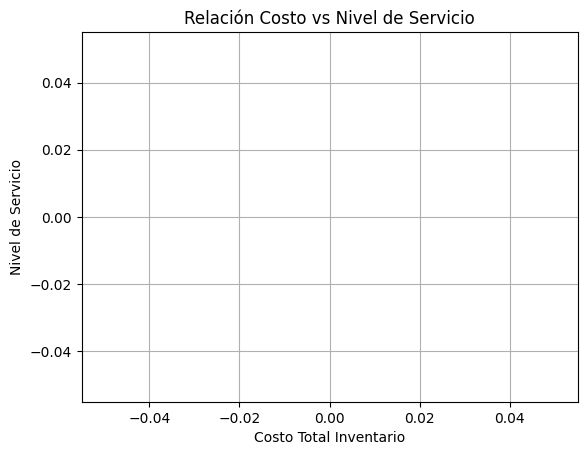

In [23]:
import matplotlib.pyplot as plt

niveles = []
costos = []

for trial in estudio.trials:
    if trial.value < 1e9:  # Sin penalización
        resultados = simulacion_unificada(
            distribuciones_tienda=distribuciones_tienda,
            distribuciones_zona=distribuciones_zona,
            ventas_tienda=ventas_tienda,
            ventas_zona=ventas_zona,
            reorden=reorden.copy(),
            dias_simulados=40,
            frecuencia_reabastecimiento=trial.params['frecuencia_reabastecimiento'],
            costo_inventario_unitario=3.733,
            reorden_multiplicador=trial.params['reorden_multiplicador']
        )
        niveles.append(resultados['nivel_servicio'])
        costos.append(resultados['costo_total'])

# Gráfico
plt.scatter(costos, niveles)
plt.xlabel("Costo Total Inventario")
plt.ylabel("Nivel de Servicio")
plt.title("Relación Costo vs Nivel de Servicio")
plt.grid(True)
plt.show()


### RESUMEN RESULTADOS
| Política                 | Nivel Servicio | Costo Total             | Demanda No Atendida  |
| ------------------------ | -------------- | ----------------------- | -------------------- |
| Base                     | 99.9%          | \$3.52 mil millones     | 457,391 unidades     |
| Óptima (sin restricción) | 26.4%          | \$380 millones          | 327 millones         |
| Penalizada               | 100.0%         | **\$1.82 mil millones** | **solo 19 unidades** |


- Política penalizada logra:
    - Mismo (o mejor) nivel de servicio que la base
    - Casi 50% de ahorro en costos
    - Prácticamente cero quiebres de stock
- La política “óptima” sin restricciones bajó costos... pero a costa de perder el 73% de la demanda.

